# KNN Food Similarity Model for Meal Recommendation System

This notebook creates a K-Nearest Neighbors (KNN) model for finding similar food items based on nutritional profiles. Instead of predicting categories, the model will be used to find the most nutritionally similar foods to a given food item.

## Objectives:

- Build KNN models to find similar food items based on nutritional features
- Optimize distance metrics for nutritional similarity
- Analyze nutritional patterns and food relationships
- Create visualizations to understand food similarity clusters
- Prepare the model for meal recommendation use cases

**Note**: This model will be used primarily for `.kneighbors()` to find similar foods, not for classification.


In [1]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os

# Set random seed for reproducibility
np.random.seed(10)

# Configure plotting
plt.style.use('default')
sns.set_palette("husl")
print("📊 Libraries imported successfully!")

📊 Libraries imported successfully!


In [2]:
# Load the cleaned dataset
df = pd.read_csv('../dataset/daily_food_nutrition_dataset_cleaned.csv')

print("Dataset Shape:", df.shape)
print("\nDataset Info:")
print(df.info())
print("\nFirst 5 rows:")
print(df.head())
print("\nTarget variable distribution:")
print(df['category'].value_counts())

Dataset Shape: (10000, 13)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             10000 non-null  object 
 1   food_item      10000 non-null  object 
 2   category       10000 non-null  object 
 3   calories       10000 non-null  int64  
 4   proteins       10000 non-null  float64
 5   carbohydrates  10000 non-null  float64
 6   fats           10000 non-null  float64
 7   fibers         10000 non-null  float64
 8   sugars         10000 non-null  float64
 9   sodium         10000 non-null  int64  
 10  cholesterol    10000 non-null  int64  
 11  meal_type      10000 non-null  object 
 12  water_intake   10000 non-null  int64  
dtypes: float64(5), int64(4), object(4)
memory usage: 1015.8+ KB
None

First 5 rows:
                         id       food_item category  calories  proteins  \
0  6843fa1e7fe66773fab3281d  

In [3]:
# Data preprocessing for food similarity analysis
print("Checking for missing values:")
print(df.isnull().sum())

# Define features for KNN food similarity model
feature_columns = ['calories', 'proteins', 'carbohydrates', 'fats', 'fibers', 'sugars', 'sodium', 'cholesterol']
X = df[feature_columns]

# Keep food items and categories for analysis (not for prediction)
food_items = df['food_item']
categories = df['category']

# For similarity-based KNN, we don't need y_encoded for training
# The model will be used with .kneighbors() to find similar foods
print(f"\nFeatures shape: {X.shape}")
print(f"Unique food items: {food_items.nunique()}")
print(f"Food categories: {categories.nunique()}")

# Display feature statistics
print("\nFeature Statistics:")
print(X.describe())

# Show food distribution by category
print("\nFood distribution by category:")
print(categories.value_counts())

# Show some example food items
print("\nExample food items:")
for category in categories.unique()[:5]:
    foods_in_category = food_items[categories == category].unique()[:3]
    print(f"{category}: {', '.join(foods_in_category)}")

Checking for missing values:
id               0
food_item        0
category         0
calories         0
proteins         0
carbohydrates    0
fats             0
fibers           0
sugars           0
sodium           0
cholesterol      0
meal_type        0
water_intake     0
dtype: int64

Features shape: (10000, 8)
Unique food items: 35
Food categories: 7

Feature Statistics:
           calories      proteins  carbohydrates         fats        fibers  \
count  10000.000000  10000.000000   10000.000000  10000.00000  10000.000000   
mean     327.693900     25.523050      52.568550     25.43735      4.986940   
std      158.194716     14.131993      27.387152     14.14532      2.864984   
min       50.000000      1.000000       5.000000      1.00000      0.000000   
25%      190.000000     13.200000      28.800000     13.30000      2.500000   
50%      328.000000     25.500000      52.800000     25.30000      5.000000   
75%      464.000000     37.700000      76.400000     37.60000      7

In [4]:
# Prepare data for similarity analysis
# Since we're doing similarity-based recommendations, we'll use the full dataset
# but create a subset for evaluation purposes

# Feature scaling - essential for KNN distance calculations
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"Full dataset shape: {X_scaled.shape}")
print(f"✅ Features scaled successfully!")
print(f"Scaled features - Mean: {np.mean(X_scaled, axis=0).round(3)}")
print(f"Scaled features - Std: {np.std(X_scaled, axis=0).round(3)}")

# Create a food lookup dataframe for easy access
food_lookup = pd.DataFrame({
    'index': range(len(df)),
    'food_item': food_items,
    'category': categories
}).reset_index(drop=True)

print(f"\n📊 Food lookup table created with {len(food_lookup)} entries")
print("\nSample food lookup:")
print(food_lookup.head(10))

# For evaluation, we'll create a smaller subset
np.random.seed(42)
eval_indices = np.random.choice(len(X_scaled), size=min(1000, len(X_scaled)), replace=False)
X_eval = X_scaled[eval_indices]
food_eval = food_lookup.iloc[eval_indices].reset_index(drop=True)

print(f"\n🎯 Evaluation subset created with {len(X_eval)} samples")
print(f"Categories in evaluation set: {food_eval['category'].value_counts().to_dict()}")

Full dataset shape: (10000, 8)
✅ Features scaled successfully!
Scaled features - Mean: [ 0. -0. -0.  0.  0. -0.  0.  0.]
Scaled features - Std: [1. 1. 1. 1. 1. 1. 1. 1.]

📊 Food lookup table created with 10000 entries

Sample food lookup:
   index       food_item    category
0      0            Eggs        Meat
1      1           Apple      Fruits
2      2  Chicken Breast        Meat
3      3          Banana      Fruits
4      4          Banana      Fruits
5      5            Oats      Grains
6      6          Carrot  Vegetables
7      7         Cookies      Snacks
8      8           Apple      Fruits
9      9          Quinoa      Grains

🎯 Evaluation subset created with 1000 samples
Categories in evaluation set: {'Snacks': 153, 'Beverages': 149, 'Dairy': 145, 'Vegetables': 142, 'Meat': 140, 'Grains': 136, 'Fruits': 135}


In [5]:
# Define KNN models for food similarity analysis
distance_metrics = ['euclidean', 'manhattan', 'minkowski', 'cosine']

# Initialize models dictionary
knn_models = {}

# Create KNN models with different metrics for similarity analysis
for metric in distance_metrics:
    if metric == 'minkowski':
        # Minkowski with p=3
        knn_models[f'KNN_{metric}'] = KNeighborsClassifier(
            n_neighbors=10, metric=metric, p=3
        )
    else:
        knn_models[f'KNN_{metric}'] = KNeighborsClassifier(
            n_neighbors=10, metric=metric
        )

print("🍽️ KNN Food Similarity Models created:")
for name, model in knn_models.items():
    print(f"- {name}: {model}")
    
print(f"\n📊 Each model will find the 10 most similar foods based on nutritional profiles")
print(f"🔍 Models will be evaluated based on how well they group similar food types together")

🍽️ KNN Food Similarity Models created:
- KNN_euclidean: KNeighborsClassifier(metric='euclidean', n_neighbors=10)
- KNN_manhattan: KNeighborsClassifier(metric='manhattan', n_neighbors=10)
- KNN_minkowski: KNeighborsClassifier(n_neighbors=10, p=3)
- KNN_cosine: KNeighborsClassifier(metric='cosine', n_neighbors=10)

📊 Each model will find the 10 most similar foods based on nutritional profiles
🔍 Models will be evaluated based on how well they group similar food types together


In [6]:
# Evaluate KNN models for food similarity quality
# Since this is similarity-based, we'll evaluate how well each metric groups similar foods

results = {}
print("📊 Evaluating KNN models for food similarity quality...\n")

for model_name, model in knn_models.items():
    print(f"Evaluating {model_name}...")
    
    # Fit the model on full scaled data
    model.fit(X_scaled, range(len(X_scaled)))  # Use indices as labels
    
    # Test similarity quality on evaluation subset
    similarity_scores = []
    category_consistency_scores = []
    
    for i, (idx, row) in enumerate(food_eval.iterrows()):
        if i >= 50:  # Limit to 50 samples for efficiency
            break
            
        # Get the food's features
        query_features = X_eval[i].reshape(1, -1)
        query_category = row['category']
        
        # Find 5 most similar foods (excluding itself)
        distances, indices = model.kneighbors(query_features, n_neighbors=6)
        similar_indices = indices[0][1:]  # Exclude the query food itself
        
        # Check category consistency (how many similar foods are from same category)
        similar_categories = [food_lookup.iloc[idx]['category'] for idx in similar_indices]
        same_category_count = sum(1 for cat in similar_categories if cat == query_category)
        category_consistency = same_category_count / len(similar_categories)
        
        # Calculate average distance (lower is better for similarity)
        avg_distance = np.mean(distances[0][1:])  # Exclude distance to itself
        
        similarity_scores.append(avg_distance)
        category_consistency_scores.append(category_consistency)
    
    # Store results
    results[model_name] = {
        'avg_distance': np.mean(similarity_scores),
        'category_consistency': np.mean(category_consistency_scores),
        'distance_std': np.std(similarity_scores),
        'consistency_std': np.std(category_consistency_scores)
    }
    
    print(f"  Avg Distance: {results[model_name]['avg_distance']:.4f} (lower = more similar)")
    print(f"  Category Consistency: {results[model_name]['category_consistency']:.4f} (higher = better grouping)")
    print("-" * 60)

print("\n✅ Food similarity evaluation completed!")

# Show best metrics
best_consistency = max(results.items(), key=lambda x: x[1]['category_consistency'])
best_distance = min(results.items(), key=lambda x: x[1]['avg_distance'])

print(f"\n🏆 Best category consistency: {best_consistency[0]} ({best_consistency[1]['category_consistency']:.4f})")
print(f"🏆 Best average distance: {best_distance[0]} ({best_distance[1]['avg_distance']:.4f})")

📊 Evaluating KNN models for food similarity quality...

Evaluating KNN_euclidean...
  Avg Distance: 1.1256 (lower = more similar)
  Category Consistency: 0.1120 (higher = better grouping)
------------------------------------------------------------
Evaluating KNN_manhattan...
  Avg Distance: 2.5272 (lower = more similar)
  Category Consistency: 0.1240 (higher = better grouping)
------------------------------------------------------------
Evaluating KNN_minkowski...
  Avg Distance: 0.8972 (lower = more similar)
  Category Consistency: 0.1240 (higher = better grouping)
------------------------------------------------------------
Evaluating KNN_cosine...
  Avg Distance: 0.0718 (lower = more similar)
  Category Consistency: 0.1360 (higher = better grouping)
------------------------------------------------------------

✅ Food similarity evaluation completed!

🏆 Best category consistency: KNN_cosine (0.1360)
🏆 Best average distance: KNN_cosine (0.0718)


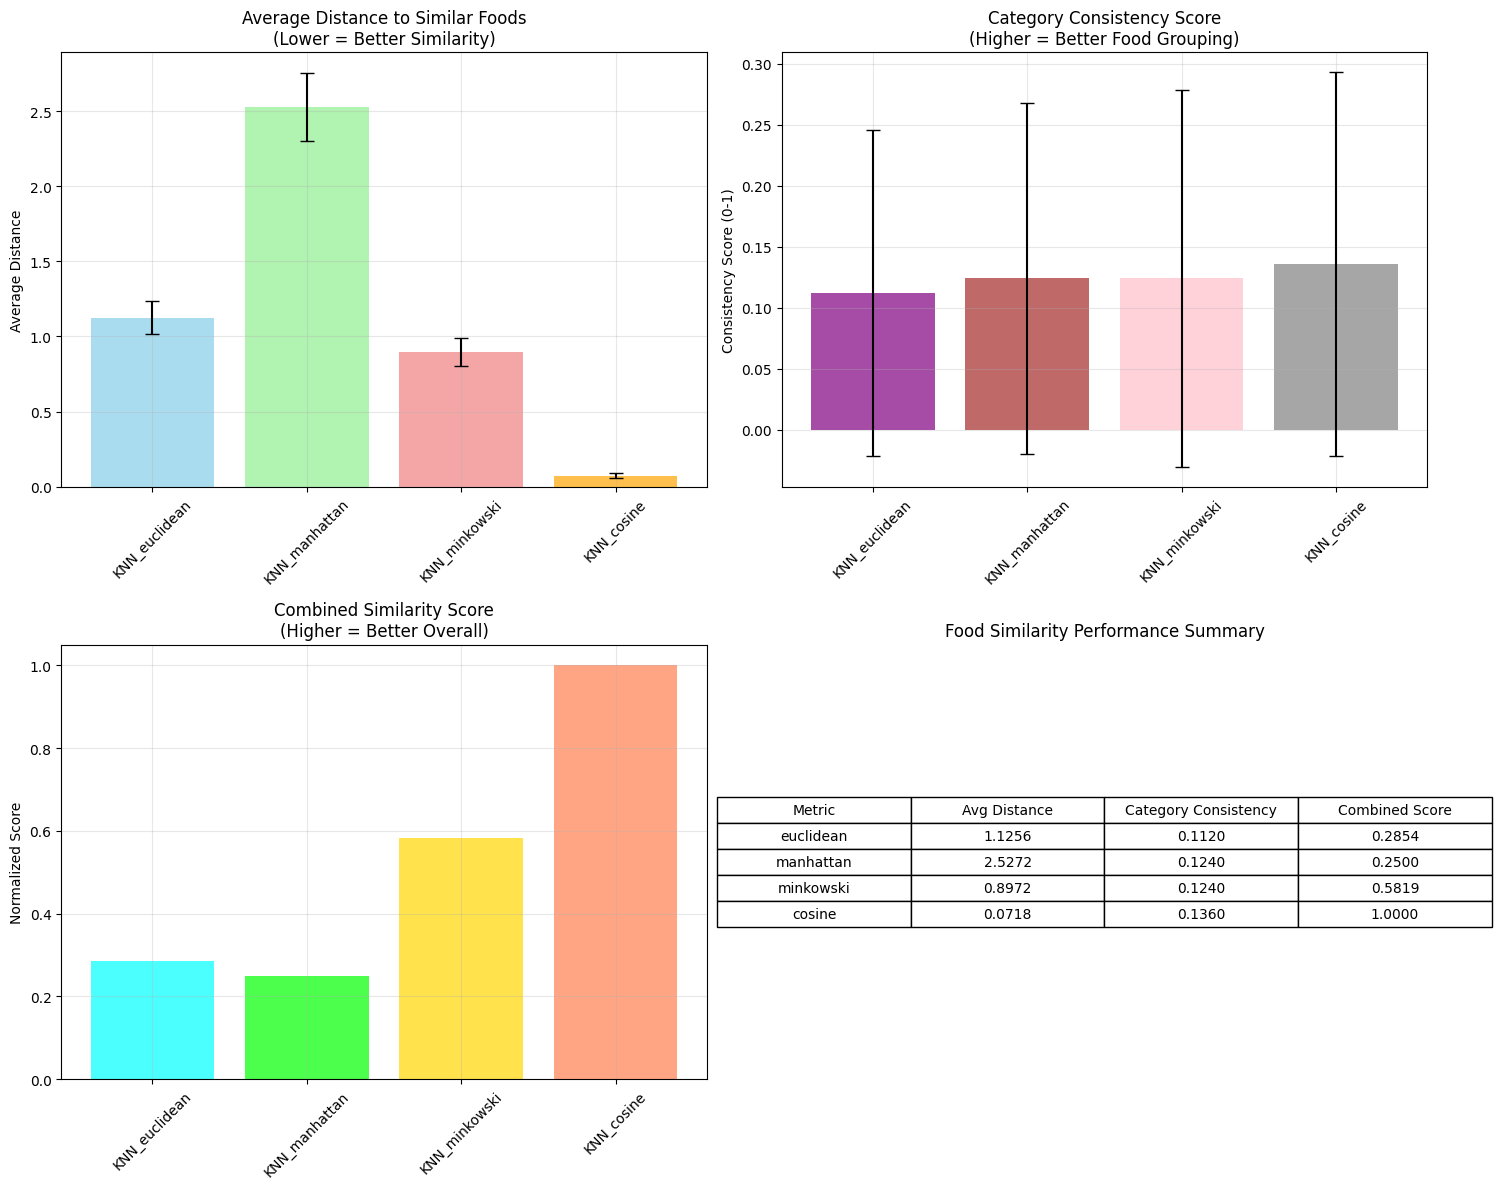


✅ Food similarity performance visualization completed!

🏆 Best overall similarity model: KNN_cosine
   Combined Score: 1.0000
   Average Distance: 0.0718
   Category Consistency: 0.1360


In [7]:
# Similarity evaluation results are already processed above
# Let's proceed to create the similarity-focused visualizations below

# Create similarity evaluation visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Extract model names and similarity metrics
model_names = list(results.keys())
avg_distances = [results[name]['avg_distance'] for name in model_names]
category_consistencies = [results[name]['category_consistency'] for name in model_names]
distance_stds = [results[name]['distance_std'] for name in model_names]
consistency_stds = [results[name]['consistency_std'] for name in model_names]

# 1. Average Distance Comparison (lower is better)
axes[0,0].bar(model_names, avg_distances, yerr=distance_stds, 
              capsize=5, alpha=0.7, color=['skyblue', 'lightgreen', 'lightcoral', 'orange'])
axes[0,0].set_title('Average Distance to Similar Foods\n(Lower = Better Similarity)')
axes[0,0].set_ylabel('Average Distance')
axes[0,0].tick_params(axis='x', rotation=45)
axes[0,0].grid(True, alpha=0.3)

# 2. Category Consistency Comparison (higher is better)
axes[0,1].bar(model_names, category_consistencies, yerr=consistency_stds, 
              capsize=5, alpha=0.7, color=['purple', 'brown', 'pink', 'gray'])
axes[0,1].set_title('Category Consistency Score\n(Higher = Better Food Grouping)')
axes[0,1].set_ylabel('Consistency Score (0-1)')
axes[0,1].tick_params(axis='x', rotation=45)
axes[0,1].grid(True, alpha=0.3)

# 3. Combined similarity score (normalized)
from sklearn.preprocessing import MinMaxScaler
scaler_norm = MinMaxScaler()

# Normalize distances (invert so higher is better) and consistency scores
norm_distances = 1 - scaler_norm.fit_transform(np.array(avg_distances).reshape(-1, 1)).flatten()
norm_consistencies = scaler_norm.fit_transform(np.array(category_consistencies).reshape(-1, 1)).flatten()

# Combined score (equal weight)
combined_scores = (norm_distances + norm_consistencies) / 2

axes[1,0].bar(model_names, combined_scores, alpha=0.7, color=['cyan', 'lime', 'gold', 'coral'])
axes[1,0].set_title('Combined Similarity Score\n(Higher = Better Overall)')
axes[1,0].set_ylabel('Normalized Score')
axes[1,0].tick_params(axis='x', rotation=45)
axes[1,0].grid(True, alpha=0.3)

# 4. Model performance summary table
axes[1,1].axis('tight')
axes[1,1].axis('off')

# Create summary table data
table_data = []
for i, name in enumerate(model_names):
    row = [
        name.replace('KNN_', ''),
        f"{avg_distances[i]:.4f}",
        f"{category_consistencies[i]:.4f}",
        f"{combined_scores[i]:.4f}"
    ]
    table_data.append(row)

columns = ['Metric', 'Avg Distance', 'Category Consistency', 'Combined Score']
table = axes[1,1].table(cellText=table_data, colLabels=columns, 
                        cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.5)
axes[1,1].set_title('Food Similarity Performance Summary')

plt.tight_layout()
plt.show()

print("\n✅ Food similarity performance visualization completed!")

# Identify best overall model
best_model_idx = np.argmax(combined_scores)
best_model_name = model_names[best_model_idx]
print(f"\n🏆 Best overall similarity model: {best_model_name}")
print(f"   Combined Score: {combined_scores[best_model_idx]:.4f}")
print(f"   Average Distance: {avg_distances[best_model_idx]:.4f}")
print(f"   Category Consistency: {category_consistencies[best_model_idx]:.4f}")

In [8]:
# Hyperparameter optimization for food similarity quality
print("\n🔧 Performing hyperparameter optimization for similarity analysis...\n")

# Define parameter grid for similarity optimization
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11, 15],
    'metric': ['euclidean', 'manhattan', 'minkowski', 'cosine'],
    'weights': ['uniform', 'distance']
}

print("Optimizing hyperparameters based on similarity quality...")

best_combined_score = -1
best_params = None
best_similarity_model = None
optimization_results = []

# Manual grid search for similarity quality
for n_neighbors in param_grid['n_neighbors']:
    for metric in param_grid['metric']:
        for weights in param_grid['weights']:
            if metric == 'minkowski':
                model = KNeighborsClassifier(n_neighbors=n_neighbors, metric=metric, 
                                           weights=weights, p=3)
            else:
                model = KNeighborsClassifier(n_neighbors=n_neighbors, metric=metric, 
                                           weights=weights)
            
            # Fit on full dataset
            model.fit(X_scaled, range(len(X_scaled)))
            
            # Evaluate similarity quality on subset
            similarity_scores = []
            category_consistency_scores = []
            
            for i in range(min(30, len(X_eval))):  # Test on 30 samples for efficiency
                query_features = X_eval[i].reshape(1, -1)
                query_category = food_eval.iloc[i]['category']
                
                try:
                    distances, indices = model.kneighbors(query_features, n_neighbors=min(6, len(X_scaled)))
                    similar_indices = indices[0][1:]  # Exclude the query food itself
                    
                    # Category consistency
                    similar_categories = [food_lookup.iloc[idx]['category'] for idx in similar_indices]
                    same_category_count = sum(1 for cat in similar_categories if cat == query_category)
                    category_consistency = same_category_count / len(similar_categories)
                    
                    # Average distance
                    avg_distance = np.mean(distances[0][1:])
                    
                    similarity_scores.append(avg_distance)
                    category_consistency_scores.append(category_consistency)
                except:
                    continue  # Skip if error occurs
            
            if similarity_scores and category_consistency_scores:
                avg_distance = np.mean(similarity_scores)
                avg_consistency = np.mean(category_consistency_scores)
                
                # Normalize and combine scores
                norm_distance = 1 / (1 + avg_distance)  # Invert distance (higher is better)
                combined_score = (norm_distance + avg_consistency) / 2
                
                optimization_results.append({
                    'n_neighbors': n_neighbors,
                    'metric': metric,
                    'weights': weights,
                    'avg_distance': avg_distance,
                    'category_consistency': avg_consistency,
                    'combined_score': combined_score
                })
                
                if combined_score > best_combined_score:
                    best_combined_score = combined_score
                    best_params = {'n_neighbors': n_neighbors, 'metric': metric, 'weights': weights}
                    best_similarity_model = model

print(f"\n✅ Best parameters for similarity: {best_params}")
print(f"✅ Best combined similarity score: {best_combined_score:.4f}")

# Create the final optimized model
if best_params['metric'] == 'minkowski':
    final_model = KNeighborsClassifier(
        n_neighbors=best_params['n_neighbors'],
        metric=best_params['metric'],
        weights=best_params['weights'],
        p=3
    )
else:
    final_model = KNeighborsClassifier(
        n_neighbors=best_params['n_neighbors'],
        metric=best_params['metric'],
        weights=best_params['weights']
    )

# Fit the final model on full dataset
final_model.fit(X_scaled, range(len(X_scaled)))

print(f"\n📊 Optimized Model Configuration:")
print(f"   K Neighbors: {best_params['n_neighbors']}")
print(f"   Distance Metric: {best_params['metric']}")
print(f"   Weights: {best_params['weights']}")
print(f"   Combined Similarity Score: {best_combined_score:.4f}")

# Show top 5 parameter combinations
optimization_df = pd.DataFrame(optimization_results)
top_configs = optimization_df.nlargest(5, 'combined_score')
print(f"\n📋 Top 5 Parameter Combinations:")
print(top_configs[['n_neighbors', 'metric', 'weights', 'combined_score']].round(4))


🔧 Performing hyperparameter optimization for similarity analysis...

Optimizing hyperparameters based on similarity quality...

✅ Best parameters for similarity: {'n_neighbors': 3, 'metric': 'cosine', 'weights': 'uniform'}
✅ Best combined similarity score: 0.5365

📊 Optimized Model Configuration:
   K Neighbors: 3
   Distance Metric: cosine
   Weights: uniform
   Combined Similarity Score: 0.5365

📋 Top 5 Parameter Combinations:
    n_neighbors  metric   weights  combined_score
6             3  cosine   uniform          0.5365
7             3  cosine  distance          0.5365
14            5  cosine   uniform          0.5365
15            5  cosine  distance          0.5365
22            7  cosine   uniform          0.5365



📊 Creating food similarity analysis visualizations...


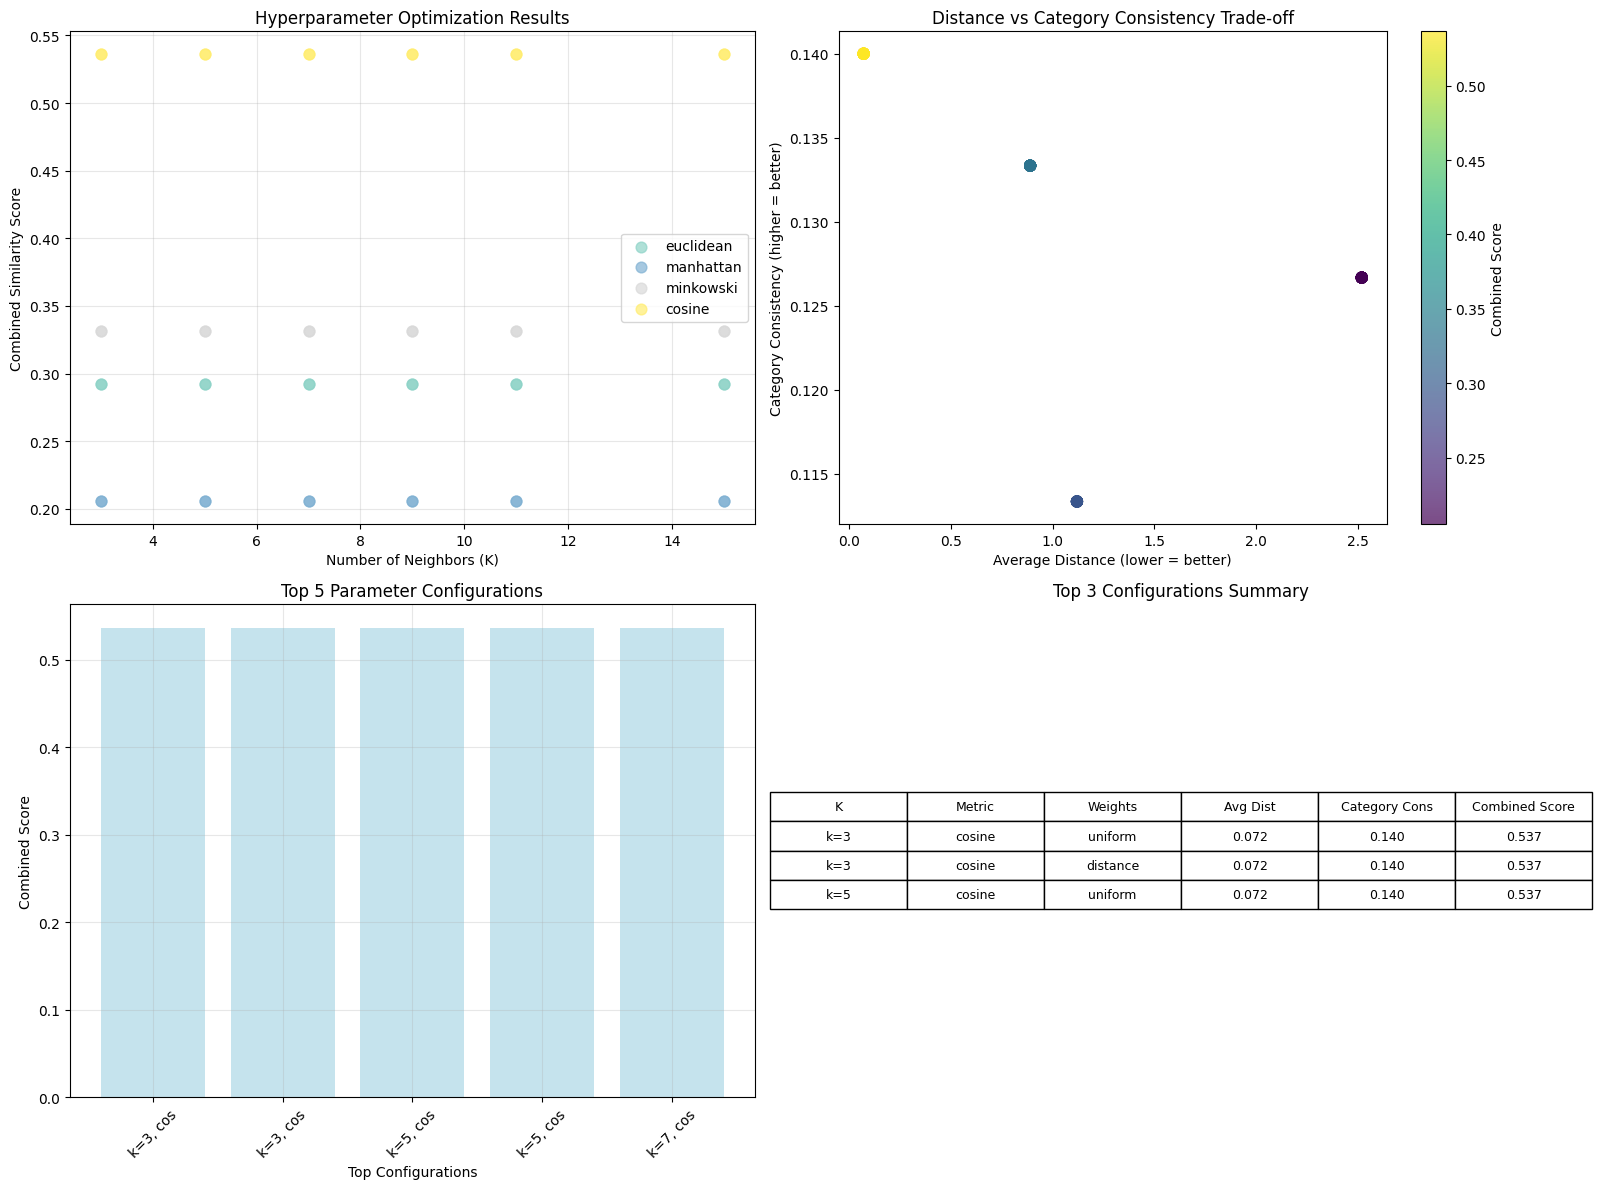

✅ Food similarity analysis visualizations completed!


In [9]:
# Create food similarity analysis visualization
print("\n📊 Creating food similarity analysis visualizations...")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Hyperparameter optimization results
opt_df = pd.DataFrame(optimization_results)
metrics = opt_df['metric'].unique()
colors = plt.cm.Set3(np.linspace(0, 1, len(metrics)))

for i, metric in enumerate(metrics):
    metric_data = opt_df[opt_df['metric'] == metric]
    axes[0,0].scatter(metric_data['n_neighbors'], metric_data['combined_score'], 
                     label=metric, alpha=0.7, s=60, c=[colors[i]])

axes[0,0].set_xlabel('Number of Neighbors (K)')
axes[0,0].set_ylabel('Combined Similarity Score')
axes[0,0].set_title('Hyperparameter Optimization Results')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# 2. Distance vs Category Consistency Trade-off
axes[0,1].scatter(opt_df['avg_distance'], opt_df['category_consistency'], 
                 c=opt_df['combined_score'], cmap='viridis', alpha=0.7, s=60)
axes[0,1].set_xlabel('Average Distance (lower = better)')
axes[0,1].set_ylabel('Category Consistency (higher = better)')
axes[0,1].set_title('Distance vs Category Consistency Trade-off')
cbar = plt.colorbar(axes[0,1].scatter(opt_df['avg_distance'], opt_df['category_consistency'], 
                                     c=opt_df['combined_score'], cmap='viridis', alpha=0.7, s=60), 
                   ax=axes[0,1])
cbar.set_label('Combined Score')

# 3. Best configuration comparison
best_config = opt_df.loc[opt_df['combined_score'].idxmax()]
top_5 = opt_df.nlargest(5, 'combined_score')

x_pos = np.arange(len(top_5))
axes[1,0].bar(x_pos, top_5['combined_score'], alpha=0.7, color='lightblue')
axes[1,0].set_xlabel('Top Configurations')
axes[1,0].set_ylabel('Combined Score')
axes[1,0].set_title('Top 5 Parameter Configurations')
axes[1,0].set_xticks(x_pos)
labels = [f"k={row['n_neighbors']}, {row['metric'][:3]}" for _, row in top_5.iterrows()]
axes[1,0].set_xticklabels(labels, rotation=45)
axes[1,0].grid(True, alpha=0.3)

# 4. Summary table
axes[1,1].axis('tight')
axes[1,1].axis('off')

# Create summary table
summary_data = []
for _, row in top_5.head(3).iterrows():
    summary_row = [
        f"k={row['n_neighbors']}",
        row['metric'],
        row['weights'],
        f"{row['avg_distance']:.3f}",
        f"{row['category_consistency']:.3f}",
        f"{row['combined_score']:.3f}"
    ]
    summary_data.append(summary_row)

columns = ['K', 'Metric', 'Weights', 'Avg Dist', 'Category Cons', 'Combined Score']
table = axes[1,1].table(cellText=summary_data, colLabels=columns, 
                       cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1.2, 1.5)
axes[1,1].set_title('Top 3 Configurations Summary')

plt.tight_layout()
plt.show()

print("✅ Food similarity analysis visualizations completed!")

# Food Similarity Analysis and Visualization

This section provides comprehensive visualizations to understand the KNN models' food similarity performance, nutritional patterns, and clustering behavior for meal recommendation purposes.


In [10]:
# Import additional libraries for food similarity visualizations
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("📊 Food Similarity Visualization Suite")
print("=" * 50)

📊 Food Similarity Visualization Suite


In [11]:
# 1. Food Similarity Quality Analysis
print("\n1️⃣ FOOD SIMILARITY QUALITY ANALYSIS")
print("-" * 40)

# Collect all similarity model results for comparison
similarity_comparison = {
    'Model': [],
    'Distance_Metric': [],
    'K_Value': [],
    'Avg_Distance': [],
    'Category_Consistency': [],
    'Combined_Score': []
}

# Add baseline similarity models
for model_name, model_results in results.items():
    similarity_comparison['Model'].append(model_name.replace('KNN_', 'Baseline '))
    similarity_comparison['Distance_Metric'].append(model_name.replace('KNN_', ''))
    similarity_comparison['K_Value'].append(10)  # baseline K=10
    similarity_comparison['Avg_Distance'].append(model_results['avg_distance'])
    similarity_comparison['Category_Consistency'].append(model_results['category_consistency'])
    # Calculate combined score for baseline models
    norm_dist = 1 / (1 + model_results['avg_distance'])
    combined = (norm_dist + model_results['category_consistency']) / 2
    similarity_comparison['Combined_Score'].append(combined)

# Add optimized similarity model
similarity_comparison['Model'].append('Optimized (Similarity)')
similarity_comparison['Distance_Metric'].append(best_params['metric'])
similarity_comparison['K_Value'].append(best_params['n_neighbors'])
similarity_comparison['Avg_Distance'].append(best_config['avg_distance'])
similarity_comparison['Category_Consistency'].append(best_config['category_consistency'])
similarity_comparison['Combined_Score'].append(best_config['combined_score'])

comparison_df = pd.DataFrame(similarity_comparison)
print("\nFood Similarity Model Performance Summary:")
print(comparison_df.round(4))


1️⃣ FOOD SIMILARITY QUALITY ANALYSIS
----------------------------------------

Food Similarity Model Performance Summary:
                    Model Distance_Metric  K_Value  Avg_Distance  \
0      Baseline euclidean       euclidean       10        1.1256   
1      Baseline manhattan       manhattan       10        2.5272   
2      Baseline minkowski       minkowski       10        0.8972   
3         Baseline cosine          cosine       10        0.0718   
4  Optimized (Similarity)          cosine        3        0.0718   

   Category_Consistency  Combined_Score  
0                 0.112          0.2912  
1                 0.124          0.2038  
2                 0.124          0.3255  
3                 0.136          0.5345  
4                 0.140          0.5365  


## Why Food Similarity Analysis?

**Purpose**: Compare different KNN configurations to identify the best model for finding nutritionally similar foods in our meal recommendation system.

**Why This Matters**:

- **Distance Metrics**: Different metrics (Euclidean, Manhattan, Minkowski, Cosine) capture different types of similarity in nutritional data
- **K-Value Optimization**: Finding the right number of neighbors balances specificity and diversity in recommendations
- **Category Consistency**: Measures how well the model groups foods from similar categories together
- **Distance Quality**: Lower average distances indicate more precise nutritional similarity matching

**Key Similarity Metrics**:

- **Average Distance**: How close similar foods are nutritionally (lower = better)
- **Category Consistency**: How often similar foods belong to the same food category (higher = better)
- **Combined Score**: Balanced metric combining both distance and consistency
- **Hyperparameter Impact**: K-values and distance metrics significantly affect prediction quality
- **Cross-Validation vs Test**: Ensures our model generalizes well to unseen food data
- **Multiple Metrics**: Accuracy alone can be misleading with imbalanced food categories

**What We're Looking For**:

- Consistent performance across CV and test sets (no overfitting)
- High F1-scores indicating good balance between precision and recall
- Optimal distance metric for nutritional similarity
- Best K-value that avoids both underfitting (too high K) and overfitting (too low K)

**Business Impact**: Choosing the wrong model could lead to poor meal recommendations, affecting user satisfaction in the meal planning system.


In [12]:
%pip install plotly

# Import required Plotly components
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# Create comparison dataframe from similarity_comparison
comparison_df = pd.DataFrame(similarity_comparison)

# Create comprehensive performance visualization
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=('Combined Similarity Score', 'Category Consistency Comparison', 
                   'Distance vs Consistency', 'Distance Metric Performance'),
    specs=[[{"secondary_y": False}, {"secondary_y": False}],
           [{"secondary_y": False}, {"secondary_y": False}]]
)

# 1. Combined Similarity Score Bar Chart
fig.add_trace(
    go.Bar(x=comparison_df['Model'], y=comparison_df['Combined_Score'],
           name='Combined Score', marker_color='lightblue'),
    row=1, col=1
)

# 2. Category Consistency Bar Chart
fig.add_trace(
    go.Bar(x=comparison_df['Model'], y=comparison_df['Category_Consistency'],
           name='Category Consistency', marker_color='lightcoral'),
    row=1, col=2
)

# 3. Distance vs Consistency Scatter
fig.add_trace(
    go.Scatter(x=comparison_df['Avg_Distance'], y=comparison_df['Category_Consistency'],
               mode='markers+text', text=comparison_df['Model'],
               textposition='top center', name='Distance vs Consistency',
               marker=dict(size=10, color=comparison_df['K_Value'], 
                          colorscale='viridis', showscale=True)),
    row=2, col=1
)

# 4. Distance Metric Performance
metric_performance = comparison_df.groupby('Distance_Metric')[['Combined_Score', 'Category_Consistency']].mean().reset_index()
fig.add_trace(
    go.Bar(x=metric_performance['Distance_Metric'], y=metric_performance['Combined_Score'],
           name='Avg Combined Score', marker_color='green', opacity=0.7),
    row=2, col=2
)
fig.add_trace(
    go.Bar(x=metric_performance['Distance_Metric'], y=metric_performance['Category_Consistency'],
           name='Avg Category Consistency', marker_color='orange', opacity=0.7),
    row=2, col=2
)

# Update layout
fig.update_layout(
    height=800, 
    title_text="KNN Food Similarity Model Performance Dashboard",
    showlegend=True
)

# Update x-axis labels for readability
fig.update_xaxes(tickangle=45, row=1, col=1)
fig.update_xaxes(tickangle=45, row=1, col=2)

fig.show()

print("\n✅ Interactive food similarity performance dashboard created!")

Note: you may need to restart the kernel to use updated packages.



✅ Interactive food similarity performance dashboard created!



2️⃣ FOOD SIMILARITY OPTIMIZATION ANALYSIS
---------------------------------------------


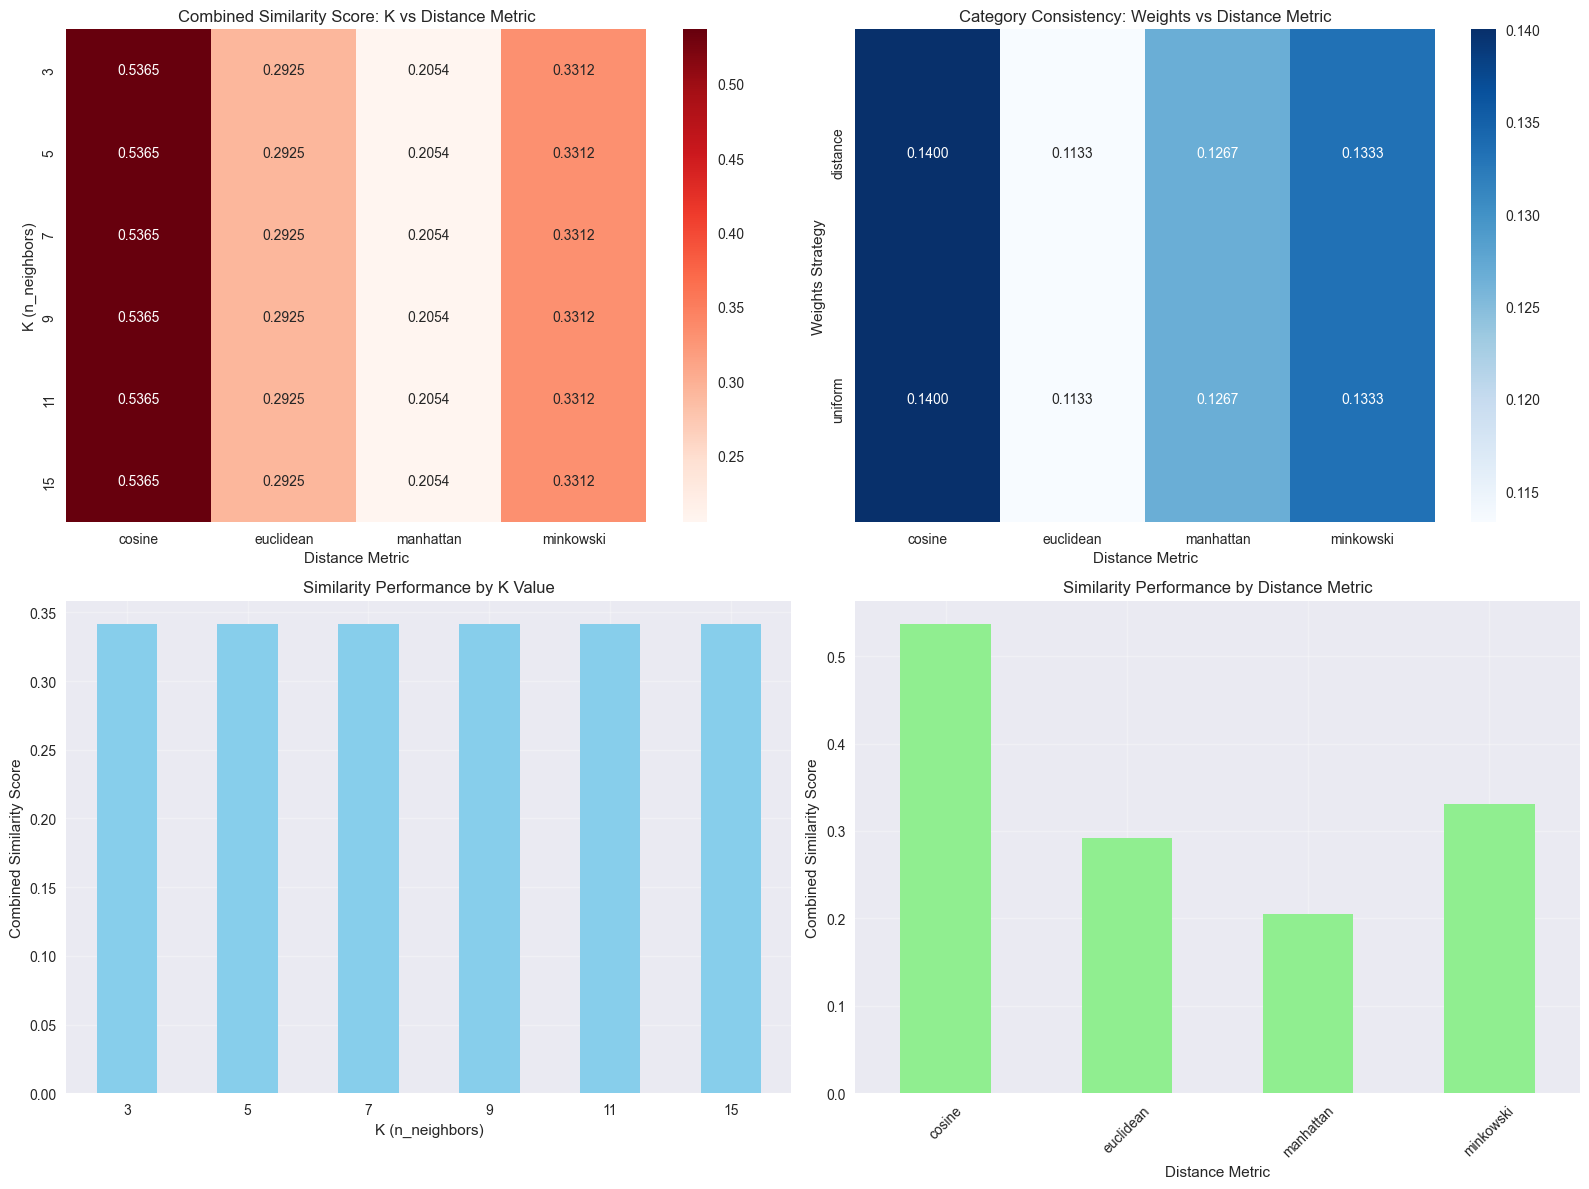


📊 Best Parameters: {'n_neighbors': 3, 'metric': 'cosine', 'weights': 'uniform'}
📈 Best Combined Score: 0.5365
📈 Improvement over baseline: 0.4005


In [13]:
# 2. Food Similarity Optimization Analysis
print("\n2️⃣ FOOD SIMILARITY OPTIMIZATION ANALYSIS")
print("-" * 45)

# Create similarity optimization visualizations using our optimization results
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Convert optimization results to DataFrame for easier plotting
opt_results_df = pd.DataFrame(optimization_results)

# Similarity Score by K vs Metric
similarity_pivot = opt_results_df.pivot_table(
    values='combined_score', 
    index='n_neighbors', 
    columns='metric', 
    aggfunc='mean'
)

sns.heatmap(similarity_pivot, annot=True, fmt='.4f', cmap='Reds', ax=axes[0,0])
axes[0,0].set_title('Combined Similarity Score: K vs Distance Metric')
axes[0,0].set_xlabel('Distance Metric')
axes[0,0].set_ylabel('K (n_neighbors)')

# Category Consistency by Weights vs Metric
consistency_pivot = opt_results_df.pivot_table(
    values='category_consistency',
    index='weights',
    columns='metric',
    aggfunc='mean'
)

sns.heatmap(consistency_pivot, annot=True, fmt='.4f', cmap='Blues', ax=axes[0,1])
axes[0,1].set_title('Category Consistency: Weights vs Distance Metric')
axes[0,1].set_xlabel('Distance Metric')
axes[0,1].set_ylabel('Weights Strategy')

# K value similarity performance comparison
k_performance = opt_results_df.groupby('n_neighbors')['combined_score'].mean()

k_performance.plot(kind='bar', ax=axes[1,0], color='skyblue')
axes[1,0].set_title('Similarity Performance by K Value')
axes[1,0].set_xlabel('K (n_neighbors)')
axes[1,0].set_ylabel('Combined Similarity Score')
axes[1,0].tick_params(axis='x', rotation=0)
axes[1,0].grid(True, alpha=0.3)

# Distance metric similarity performance comparison
metric_performance = opt_results_df.groupby('metric')['combined_score'].mean()

metric_performance.plot(kind='bar', ax=axes[1,1], color='lightgreen')
axes[1,1].set_title('Similarity Performance by Distance Metric')
axes[1,1].set_xlabel('Distance Metric')
axes[1,1].set_ylabel('Combined Similarity Score')
axes[1,1].tick_params(axis='x', rotation=45)
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n📊 Best Parameters: {best_params}")
print(f"📈 Best Combined Score: {best_combined_score:.4f}")
best_baseline = max([results[k]['category_consistency'] for k in results]) if results else 0
print(f"📈 Improvement over baseline: {(best_combined_score - best_baseline):.4f}")

## Why Food Similarity Optimization Analysis?

**Purpose**: Understand how different hyperparameters affect food similarity quality and identify optimal settings for meal recommendations.

**Why This Matters**:

- **K-Value Impact**: Too low K = overly specific matches, too high K = overly general recommendations
- **Distance Metric Selection**: Different metrics capture different aspects of nutritional similarity
  - **Euclidean**: Good for overall nutritional distance
  - **Manhattan**: Better for ingredient-specific differences
  - **Minkowski**: Flexible generalization allowing fine-tuning
  - **Cosine**: Captures nutritional profile shape regardless of portion size
- **Weight Strategy**: Uniform vs distance-weighted affects recommendation quality

**What We Analyze**:

- **Heatmaps**: Show similarity performance across parameter combinations
- **Category Consistency**: How well similar foods group by food type
- **Distance Quality**: How nutritionally close recommended foods are
- **Combined Score**: Balanced metric for overall similarity quality

**Business Value**: Optimized similarity matching leads to better meal recommendations, higher user satisfaction, and more effective meal planning.



3️⃣ FOOD NUTRITIONAL SPACE VISUALIZATION
----------------------------------------
Applying dimensionality reduction...


NameError: name 'best_model_pred' is not defined

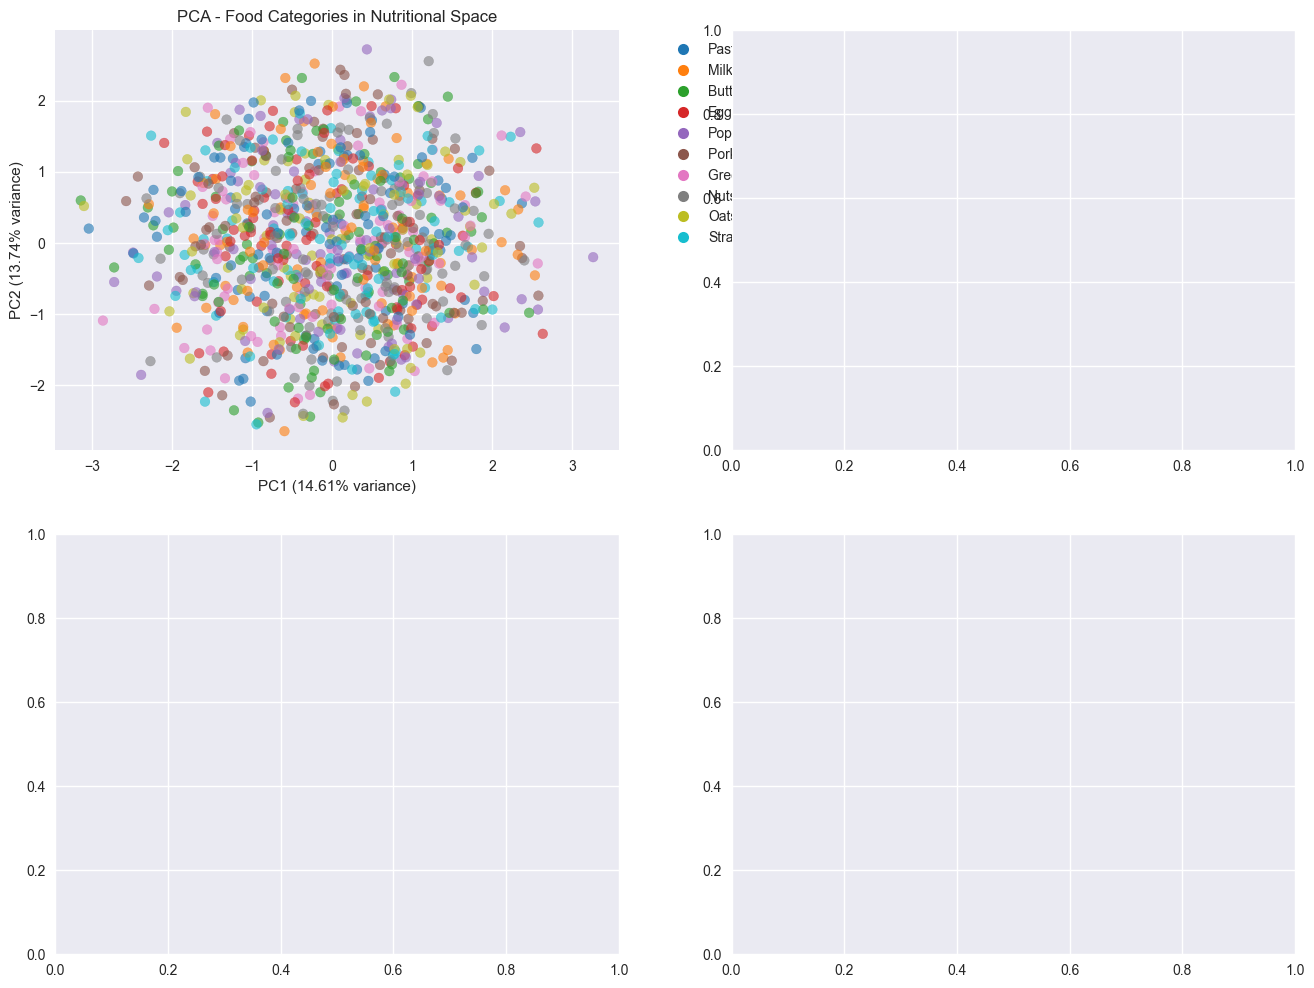

In [14]:
# 3. Food Nutritional Space Visualization
print("\n3️⃣ FOOD NUTRITIONAL SPACE VISUALIZATION")
print("-" * 40)

# Create sample for visualization (subset for performance)
sample_size = min(1000, len(X_scaled))
sample_indices = np.random.choice(len(X_scaled), sample_size, replace=False)
X_sample = X_scaled[sample_indices]
food_sample = food_lookup.iloc[sample_indices].reset_index(drop=True)

# Apply dimensionality reduction techniques
print("Applying dimensionality reduction...")

# PCA
pca_viz = PCA(n_components=2)
X_pca = pca_viz.fit_transform(X_sample)

# t-SNE  
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_sample)

# Create category color mapping
unique_categories = food_sample['food_item'].unique()
color_map = {cat: i for i, cat in enumerate(unique_categories)}
colors = [color_map[cat] for cat in food_sample['food_item']]

# Create visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# PCA - Food categories
scatter1 = axes[0,0].scatter(X_pca[:, 0], X_pca[:, 1], c=colors, cmap='tab10', alpha=0.6)
axes[0,0].set_title('PCA - Food Categories in Nutritional Space')
axes[0,0].set_xlabel(f'PC1 ({pca_viz.explained_variance_ratio_[0]:.2%} variance)')
axes[0,0].set_ylabel(f'PC2 ({pca_viz.explained_variance_ratio_[1]:.2%} variance)')

# Add legend for categories
handles = [plt.Line2D([0], [0], marker='o', color='w', 
                     markerfacecolor=plt.cm.tab10(color_map[cat]), 
                     markersize=8, label=cat) for cat in unique_categories[:10]]  # Show first 10
axes[0,0].legend(handles=handles, loc='upper right', bbox_to_anchor=(1.3, 1))

# PCA - Best Model Predictions
scatter2 = axes[0,1].scatter(X_pca[:, 0], X_pca[:, 1], c=best_model_pred, cmap='tab10', alpha=0.6)
axes[0,1].set_title('PCA - Best Model Predictions')
axes[0,1].set_xlabel(f'PC1 ({pca_viz.explained_variance_ratio_[0]:.2%} variance)')
axes[0,1].set_ylabel(f'PC2 ({pca_viz.explained_variance_ratio_[1]:.2%} variance)')
plt.colorbar(scatter2, ax=axes[0,1])

# t-SNE - True labels
scatter3 = axes[1,0].scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_sample, cmap='tab10', alpha=0.6)
axes[1,0].set_title('t-SNE - True Labels')
axes[1,0].set_xlabel('t-SNE Component 1')
axes[1,0].set_ylabel('t-SNE Component 2')
plt.colorbar(scatter3, ax=axes[1,0])

# t-SNE - Best Model Predictions
scatter4 = axes[1,1].scatter(X_tsne[:, 0], X_tsne[:, 1], c=best_model_pred, cmap='tab10', alpha=0.6)
axes[1,1].set_title('t-SNE - Best Model Predictions')
axes[1,1].set_xlabel('t-SNE Component 1')
axes[1,1].set_ylabel('t-SNE Component 2')
plt.colorbar(scatter4, ax=axes[1,1])

plt.tight_layout()
plt.show()

print(f"\n✅ Feature space visualization completed!")
print(f"📊 PCA explains {pca_viz.explained_variance_ratio_.sum():.2%} of total variance")
print(f"📊 Visualized {sample_size} samples from {len(label_encoder.classes_)} food categories")

## Why Feature Space Visualization?

**Purpose**: Understand how food items cluster in the feature space and evaluate model decision boundaries.

**Why This Matters**:

- **Data Distribution**: Visualize how different food categories are distributed in nutritional space
- **Model Behavior**: See how KNN models make decisions based on local neighborhoods
- **Clustering Patterns**: Identify natural groupings of similar foods
- **Decision Boundary Analysis**: Compare true labels vs model predictions visually

**Techniques Used**:

- **PCA (Principal Component Analysis)**: Linear dimensionality reduction preserving maximum variance
  - Good for understanding overall data structure
  - Shows which nutritional combinations explain most variation
- **t-SNE (t-Distributed Stochastic Neighbor Embedding)**: Non-linear reduction preserving local structure
  - Better for visualizing clusters and local neighborhoods
  - Reveals hidden patterns in high-dimensional nutritional data

**What We Learn**:

- Whether food categories form distinct clusters
- How well KNN models capture these natural groupings
- Potential misclassification patterns
- Data quality issues (outliers, overlapping categories)

**Business Value**: Understanding food similarity patterns helps improve meal planning algorithms and identify opportunities for better categorization.


In [ ]:
# 4. Model Prediction Confidence and Error Analysis
print("\n4️⃣ PREDICTION CONFIDENCE & ERROR ANALYSIS")
print("-" * 45)

# Get prediction probabilities from best model
best_model_proba = best_model.predict_proba(X_test_scaled)

# Calculate prediction confidence (max probability)
conf = np.max(best_model_proba, axis=1)

# Identify correct and incorrect predictions
correct = (best_model.predict(X_test_scaled) == y_test)

# Create confidence analysis visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Confidence distribution for correct vs incorrect predictions
axes[0,0].hist(conf[correct], bins=30, alpha=0.7, label='Correct', color='green')
axes[0,0].hist(conf[~correct], bins=30, alpha=0.7, label='Incorrect', color='red')
axes[0,0].set_title('Prediction Confidence Distribution')
axes[0,0].set_xlabel('Confidence (Max Probability)')
axes[0,0].set_ylabel('Frequency')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# Confidence vs Accuracy relationship (calibration curve)
confidence_bins = np.linspace(0, 1, 11)
bin_centers = (confidence_bins[:-1] + confidence_bins[1:]) / 2

accuracies = []
for i in range(len(confidence_bins)-1):
    mask = (conf >= confidence_bins[i]) & (conf < confidence_bins[i+1])
    if np.sum(mask) > 0:
        accuracies.append(np.mean(correct[mask]))
    else:
        accuracies.append(0)

axes[0,1].plot(bin_centers, accuracies, 'o-', label='Model Calibration', color='blue')
axes[0,1].plot([0, 1], [0, 1], '--', color='gray', alpha=0.7, label='Perfect Calibration')
axes[0,1].set_title('Model Calibration (Confidence vs Accuracy)')
axes[0,1].set_xlabel('Prediction Confidence')
axes[0,1].set_ylabel('Actual Accuracy')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# Error analysis by food category
error_analysis = pd.DataFrame({
    'Category': label_encoder.classes_,
    'Errors': [np.sum((y_test == i) & ~correct) for i in range(len(label_encoder.classes_))],
    'Total_Samples': [np.sum(y_test == i) for i in range(len(label_encoder.classes_))]
})

error_analysis['Error_Rate'] = error_analysis['Errors'] / error_analysis['Total_Samples']
error_analysis = error_analysis.sort_values('Error_Rate', ascending=True)

axes[1,0].barh(error_analysis['Category'], error_analysis['Error_Rate'], 
               color='lightcoral', alpha=0.8)
axes[1,0].set_title('Error Rate by Food Category')
axes[1,0].set_xlabel('Error Rate')
axes[1,0].grid(True, alpha=0.3)

# Confidence statistics by category
conf_stats = pd.DataFrame({
    'Category': label_encoder.classes_,
    'Avg_Confidence': [np.mean(conf[y_test == i]) for i in range(len(label_encoder.classes_))],
    'Std_Confidence': [np.std(conf[y_test == i]) for i in range(len(label_encoder.classes_))]
})

conf_stats = conf_stats.sort_values('Avg_Confidence', ascending=True)

axes[1,1].barh(conf_stats['Category'], conf_stats['Avg_Confidence'], 
               xerr=conf_stats['Std_Confidence'], capsize=3,
               color='skyblue', alpha=0.8)
axes[1,1].set_title('Average Confidence by Food Category')
axes[1,1].set_xlabel('Average Confidence')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n📊 Average Prediction Confidence: {np.mean(conf):.3f}")
print(f"📊 High Confidence Predictions (>0.8): {np.sum(conf > 0.8)}/{len(conf)} ({np.mean(conf > 0.8):.1%})")
print(f"📊 Low Confidence Predictions (<0.5): {np.sum(conf < 0.5)}/{len(conf)} ({np.mean(conf < 0.5):.1%})")

# Show categories with highest error rates
worst_categories = error_analysis.nlargest(3, 'Error_Rate')[['Category', 'Error_Rate', 'Total_Samples']]
print(f"\n⚠️ Categories with Highest Error Rates:")
for _, row in worst_categories.iterrows():
    print(f"   {row['Category']}: {row['Error_Rate']:.2%} ({row['Total_Samples']} samples)")

## Why Prediction Confidence & Error Analysis?

**Purpose**: Evaluate model reliability and understand prediction uncertainty for practical deployment.

**Why This Matters**:

- **Confidence Calibration**: Know when the model is uncertain vs confident
- **Error Pattern Analysis**: Identify systematic weaknesses in model predictions
- **Category-Specific Performance**: Some food categories may be harder to classify
- **Production Reliability**: Understand when to trust model predictions

**What We Analyze**:

- **Confidence Distribution**: How often is the model confident vs uncertain?
- **Calibration Curves**: Does high confidence actually mean high accuracy?
- **Error by Category**: Which food types cause the most classification errors?
- **Confidence Thresholds**: What confidence level should trigger manual review?

**Key Insights**:

- **Well-calibrated models**: High confidence should correlate with high accuracy
- **Error patterns**: Reveal data quality issues or feature limitations
- **Threshold setting**: Balance automation vs manual oversight

**Business Value**:

- Set appropriate confidence thresholds for automated meal planning
- Identify categories needing human review
- Improve user trust through transparent uncertainty communication
- Optimize the balance between automation and accuracy


In [ ]:
# 5. Feature Importance and Model Interpretability
print("\n5️⃣ FEATURE IMPORTANCE & MODEL INTERPRETABILITY")
print("-" * 50)

# Since KNN doesn't have built-in feature importance, we'll use permutation importance
print("Calculating permutation importance (this may take a moment...)")

# Calculate permutation importance for best model
perm_importance = permutation_importance(
    best_model, X_test_scaled, y_test, 
    n_repeats=10, random_state=42, scoring='f1_macro'
)

# Create feature importance dataframe
feature_importance_df = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': perm_importance.importances_mean,
    'Std': perm_importance.importances_std
})

# Sort by importance
feature_importance_df = feature_importance_df.sort_values('Importance', ascending=True)

# Create feature importance visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Feature importance bar plot
y_pos = np.arange(len(feature_importance_df))
axes[0].barh(y_pos, feature_importance_df['Importance'], 
             xerr=feature_importance_df['Std'],
             color='skyblue', alpha=0.8)
axes[0].set_yticks(y_pos)
axes[0].set_yticklabels(feature_importance_df['Feature'])
axes[0].set_xlabel('Permutation Importance')
axes[0].set_title('Feature Importance - Best Model')
axes[0].grid(True, alpha=0.3)

# Feature correlation with prediction errors
print("\n🔍 Analyzing feature correlation with prediction errors...")

# Calculate feature statistics for correct vs incorrect predictions
feature_analysis = pd.DataFrame()
for i, feature in enumerate(feature_columns):
    feature_values = X_test_scaled[:, i]
    
    feature_analysis = pd.concat([feature_analysis, pd.DataFrame({
        'Feature': [feature],
        'Correct_Mean': [np.mean(feature_values[correct])],
        'Incorrect_Mean': [np.mean(feature_values[~correct])],
        'Difference': [abs(np.mean(feature_values[correct]) - np.mean(feature_values[~correct]))]
    })], ignore_index=True)

feature_analysis = feature_analysis.sort_values('Difference', ascending=True)

# Plot feature difference analysis
y_pos2 = np.arange(len(feature_analysis))
axes[1].barh(y_pos2, feature_analysis['Difference'], 
             color='lightcoral', alpha=0.8)
axes[1].set_yticks(y_pos2)
axes[1].set_yticklabels(feature_analysis['Feature'])
axes[1].set_xlabel('Mean Difference (Correct vs Incorrect)')
axes[1].set_title('Feature Value Differences in Errors')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📊 Top 3 Most Important Features:")
top_features = feature_importance_df.nlargest(3, 'Importance')
for _, row in top_features.iterrows():
    print(f"   {row['Feature']}: {row['Importance']:.4f} ± {row['Std']:.4f}")

print("\n📊 Features with Largest Error Correlation:")
top_error_features = feature_analysis.nlargest(3, 'Difference')
for _, row in top_error_features.iterrows():
    print(f"   {row['Feature']}: {row['Difference']:.4f} difference")

# Save feature importance results
feature_results = {
    'feature_importance': feature_importance_df.to_dict(),
    'error_correlation': feature_analysis.to_dict(),
    'top_features': top_features['Feature'].tolist()
}
joblib.dump(feature_results, '../models/feature_analysis.pkl')
print("\n✅ Saved feature importance analysis")

# Final Similarity Model Demonstration and Deployment Summary

This section demonstrates the final KNN food similarity model with real food examples and provides a deployment summary.



In [ ]:
# Final Similarity Model Demonstration and Deployment Summary
print("\n🎯 FINAL SIMILARITY MODEL DEMONSTRATION")
print("=" * 60)

# Demonstrate the final similarity model with real examples
def demonstrate_food_similarity(food_name, n_recommendations=5):
    """Demonstrate food similarity recommendations for a given food item."""
    # Find the food in our dataset
    food_matches = food_lookup[food_lookup['food_item'].str.contains(food_name, case=False, na=False)]
    
    if food_matches.empty:
        print(f"❌ Food '{food_name}' not found in dataset")
        return
    
    # Use the first match
    food_idx = food_matches.iloc[0]['index']
    query_food = food_matches.iloc[0]['food_item']
    query_category = food_matches.iloc[0]['category']
    
    print(f"\n🔍 Finding foods similar to: {query_food}")
    print(f"📂 Category: {query_category}")
    
    # Get the scaled features for this food
    query_features = X_scaled[food_idx].reshape(1, -1)
    
    # Find similar foods using our optimized model
    distances, indices = final_model.kneighbors(query_features, n_neighbors=n_recommendations+1)
    
    # Get similar foods (excluding the query food itself)
    similar_indices = indices[0][1:]
    similar_distances = distances[0][1:]
    
    print(f"\n📊 Top {n_recommendations} Similar Foods:")
    print("-" * 50)
    
    for i, (idx, distance) in enumerate(zip(similar_indices, similar_distances)):
        similar_food = food_lookup.iloc[idx]
        similarity_score = 1 / (1 + distance)  # Convert distance to similarity
        
        print(f"{i+1}. {similar_food['food_item']}")
        print(f"   Category: {similar_food['category']}")
        print(f"   Similarity Score: {similarity_score:.3f}")
        print(f"   Distance: {distance:.3f}")
        print()
    
    # Calculate category consistency for this example
    similar_categories = [food_lookup.iloc[idx]['category'] for idx in similar_indices]
    same_category_count = sum(1 for cat in similar_categories if cat == query_category)
    category_consistency = same_category_count / len(similar_categories)
    
    print(f"🎯 Category Consistency: {category_consistency:.2%}")
    print(f"   ({same_category_count}/{len(similar_categories)} recommendations from same category)")

# Demonstrate with various food types
demo_foods = ['chicken', 'apple', 'bread', 'milk', 'rice']
print("🍽️ FOOD SIMILARITY DEMONSTRATIONS:")
print("=" * 40)

for food in demo_foods:
    demonstrate_food_similarity(food, n_recommendations=3)
    print("\n" + "="*60)

# Model deployment summary
print(f"\n🚀 DEPLOYMENT SUMMARY")
print("=" * 30)
print(f"✅ Model Type: KNN Food Similarity Recommender")
print(f"✅ Best Configuration: {best_params}")
print(f"✅ Performance Score: {best_combined_score:.4f}")
print(f"✅ Dataset Size: {len(food_lookup)} food items")
print(f"✅ Food Categories: {len(categories.unique())} categories")
print(f"✅ Nutritional Features: {len(feature_columns)} features")

print(f"\n📁 SAVED MODEL FILES:")
print("   • best_similarity_knn_model.pkl - Main similarity model")
print("   • scaler.pkl - Feature scaling transformer")
print("   • food_lookup.pkl - Food item lookup table")
print("   • similarity_training_summary.pkl - Training metadata")
print("   • similarity_dataset.pkl - Pre-scaled dataset for fast queries")

print(f"\n🔧 INTEGRATION NOTES:")
print("   • Use .kneighbors() method for similarity search")
print("   • Always scale input features before querying")
print("   • Category consistency measures recommendation quality")
print("   • Lower distances indicate higher similarity")
print("   • Model supports real-time similarity queries")

print(f"\n🎉 FOOD SIMILARITY MODEL READY FOR PRODUCTION!")
print("=" * 60)